In [1]:
"""
Defines a class that is used to featurize audio clips, and provide
them to the network for training or testing.
"""

import json
import numpy as np
import random
from python_speech_features import mfcc
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import calc_feat_dim, spectrogram_from_file, text_to_int_sequence
from utils import conv_output_length

RNG_SEED = 123

class AudioGenerator():
    def __init__(self, step=10, window=20, max_freq=8000, mfcc_dim=13,
        minibatch_size=20, desc_file=None, spectrogram=True, max_duration=10.0, 
        sort_by_duration=False):
        """
        Params:
            step (int): Step size in milliseconds between windows (for spectrogram ONLY)
            window (int): FFT window size in milliseconds (for spectrogram ONLY)
            max_freq (int): Only FFT bins corresponding to frequencies between
                [0, max_freq] are returned (for spectrogram ONLY)
            desc_file (str, optional): Path to a JSON-line file that contains
                labels and paths to the audio files. If this is None, then
                load metadata right away
        """

        self.feat_dim = calc_feat_dim(window, max_freq)
        self.mfcc_dim = mfcc_dim
        self.feats_mean = np.zeros((self.feat_dim,))
        self.feats_std = np.ones((self.feat_dim,))
        self.rng = random.Random(RNG_SEED)
        if desc_file is not None:
            self.load_metadata_from_desc_file(desc_file)
        self.step = step
        self.window = window
        self.max_freq = max_freq
        self.cur_train_index = 0
        self.cur_valid_index = 0
        self.cur_test_index = 0
        self.max_duration=max_duration
        self.minibatch_size = minibatch_size
        self.spectrogram = spectrogram
        self.sort_by_duration = sort_by_duration

    def get_batch(self, partition):
        """ Obtain a batch of train, validation, or test data
        """
        if partition == 'train':
            audio_paths = self.train_audio_paths
            cur_index = self.cur_train_index
            texts = self.train_texts
        elif partition == 'valid':
            audio_paths = self.valid_audio_paths
            cur_index = self.cur_valid_index
            texts = self.valid_texts
        elif partition == 'test':
            audio_paths = self.test_audio_paths
            cur_index = self.test_valid_index
            texts = self.test_texts
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

        features = [self.normalize(self.featurize(a)) for a in 
            audio_paths[cur_index:cur_index+self.minibatch_size]]

        # calculate necessary sizes
        max_length = max([features[i].shape[0] 
            for i in range(0, self.minibatch_size)])
        max_string_length = max([len(texts[cur_index+i]) 
            for i in range(0, self.minibatch_size)])
        
        # initialize the arrays
        X_data = np.zeros([self.minibatch_size, max_length, 
            self.feat_dim*self.spectrogram + self.mfcc_dim*(not self.spectrogram)])
        labels = np.ones([self.minibatch_size, max_string_length]) * 28
        input_length = np.zeros([self.minibatch_size, 1])
        label_length = np.zeros([self.minibatch_size, 1])
        
        for i in range(0, self.minibatch_size):
            # calculate X_data & input_length
            feat = features[i]
            input_length[i] = feat.shape[0]
            X_data[i, :feat.shape[0], :] = feat

            # calculate labels & label_length
            label = np.array(text_to_int_sequence(texts[cur_index+i])) 
            labels[i, :len(label)] = label
            label_length[i] = len(label)
 
        # return the arrays
        outputs = {'ctc': np.zeros([self.minibatch_size])}
        inputs = {'the_input': X_data, 
                  'the_labels': labels, 
                  'input_length': input_length, 
                  'label_length': label_length 
                 }
        return (inputs, outputs)

    def shuffle_data_by_partition(self, partition):
        """ Shuffle the training or validation data
        """
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = shuffle_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = shuffle_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def sort_data_by_duration(self, partition):
        """ Sort the training or validation sets by (increasing) duration
        """
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = sort_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = sort_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def next_train(self):
        """ Obtain a batch of training data
        """
        while True:
            ret = self.get_batch('train')
            self.cur_train_index += self.minibatch_size
            if self.cur_train_index >= len(self.train_texts) - self.minibatch_size:
                self.cur_train_index = 0
                self.shuffle_data_by_partition('train')
            yield ret    

    def next_valid(self):
        """ Obtain a batch of validation data
        """
        while True:
            ret = self.get_batch('valid')
            self.cur_valid_index += self.minibatch_size
            if self.cur_valid_index >= len(self.valid_texts) - self.minibatch_size:
                self.cur_valid_index = 0
                self.shuffle_data_by_partition('valid')
            yield ret

    def next_test(self):
        """ Obtain a batch of test data
        """
        while True:
            ret = self.get_batch('test')
            self.cur_test_index += self.minibatch_size
            if self.cur_test_index >= len(self.test_texts) - self.minibatch_size:
                self.cur_test_index = 0
            yield ret

    def load_train_data(self, desc_file='train_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'train')
        self.fit_train()
        if self.sort_by_duration:
            self.sort_data_by_duration('train')

    def load_validation_data(self, desc_file='valid_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'validation')
        if self.sort_by_duration:
            self.sort_data_by_duration('valid')

    def load_test_data(self, desc_file='test_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'test')
    
    def load_metadata_from_desc_file(self, desc_file, partition):
        """ Read metadata from a JSON-line file
            (possibly takes long, depending on the filesize)
        Params:
            desc_file (str):  Path to a JSON-line file that contains labels and
                paths to the audio files
            partition (str): One of 'train', 'validation' or 'test'
        """
        audio_paths, durations, texts = [], [], []
        with open(desc_file) as json_line_file:
            for line_num, json_line in enumerate(json_line_file):
                try:
                    spec = json.loads(json_line)
                    if float(spec['duration']) > self.max_duration:
                        continue
                    audio_paths.append(spec['key'])
                    durations.append(float(spec['duration']))
                    texts.append(spec['text'])
                except Exception as e:
                    # Change to (KeyError, ValueError) or
                    # (KeyError,json.decoder.JSONDecodeError), depending on
                    # json module version
                    print('Error reading line #{}: {}'
                                .format(line_num, json_line))
        if partition == 'train':
            self.train_audio_paths = audio_paths
            self.train_durations = durations
            self.train_texts = texts
        elif partition == 'validation':
            self.valid_audio_paths = audio_paths
            self.valid_durations = durations
            self.valid_texts = texts
        elif partition == 'test':
            self.test_audio_paths = audio_paths
            self.test_durations = durations
            self.test_texts = texts
        else:
            raise Exception("Invalid partition to load metadata. "
             "Must be train/validation/test")
            
    def fit_train(self, k_samples=100):
        """ Estimate the mean and std of the features from the training set
        Params:
            k_samples (int): Use this number of samples for estimation
        """
        k_samples = min(k_samples, len(self.train_audio_paths))
        samples = self.rng.sample(self.train_audio_paths, k_samples)
        feats = [self.featurize(s) for s in samples]
        feats = np.vstack(feats)
        self.feats_mean = np.mean(feats, axis=0)
        self.feats_std = np.std(feats, axis=0)
        
    def featurize(self, audio_clip):
        """ For a given audio clip, calculate the corresponding feature
        Params:
            audio_clip (str): Path to the audio clip
        """
        if self.spectrogram:
            return spectrogram_from_file(
                audio_clip, step=self.step, window=self.window,
                max_freq=self.max_freq)
        else:
            (rate, sig) = wav.read(audio_clip)
            return mfcc(sig, rate, numcep=self.mfcc_dim)

    def normalize(self, feature, eps=1e-14):
        """ Center a feature using the mean and std
        Params:
            feature (numpy.ndarray): Feature to normalize
        """
        return (feature - self.feats_mean) / (self.feats_std + eps)

def shuffle_data(audio_paths, durations, texts):
    """ Shuffle the data (called after making a complete pass through 
        training or validation data during the training process)
    Params:
        audio_paths (list): Paths to audio clips
        durations (list): Durations of utterances for each audio clip
        texts (list): Sentences uttered in each audio clip
    """
    p = np.random.permutation(len(audio_paths))
    audio_paths = [audio_paths[i] for i in p] 
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

def sort_data(audio_paths, durations, texts):
    """ Sort the data by duration 
    Params:
        audio_paths (list): Paths to audio clips
        durations (list): Durations of utterances for each audio clip
        texts (list): Sentences uttered in each audio clip
    """
    p = np.argsort(durations).tolist()
    audio_paths = [audio_paths[i] for i in p]
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

def vis_train_features(index=0):
    """ Visualizing the data point in the training set at the supplied index
    """
    # obtain spectrogram
    audio_gen = AudioGenerator(spectrogram=True)
    audio_gen.load_train_data()
    vis_audio_path = audio_gen.train_audio_paths[index]
    vis_spectrogram_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # obtain mfcc
    audio_gen = AudioGenerator(spectrogram=False)
    audio_gen.load_train_data()
    vis_mfcc_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # obtain text label
    vis_text = audio_gen.train_texts[index]
    # obtain raw audio
    vis_raw_audio, _ = librosa.load(vis_audio_path)
    # print total number of training examples
    print('There are %d total training examples.' % len(audio_gen.train_audio_paths))
    # return labels for plotting
    return vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path


def plot_raw_audio(vis_raw_audio):
    # plot the raw audio signal
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    steps = len(vis_raw_audio)
    ax.plot(np.linspace(1, steps, steps), vis_raw_audio)
    plt.title('Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def plot_mfcc_feature(vis_mfcc_feature):
    # plot the MFCC feature
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_mfcc_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()

def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()


In [2]:
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2136 total training examples.


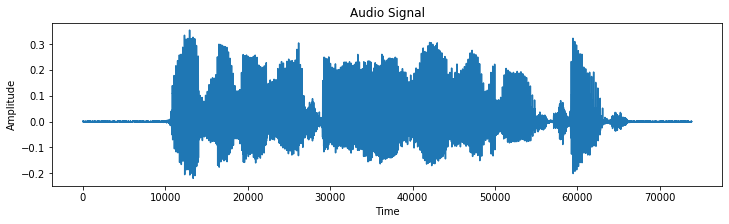

**Shape of Audio Signal** : (73868,)

**Transcript** : he had neither a national army nor an organized church

In [3]:
from IPython.display import Markdown, display
#from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

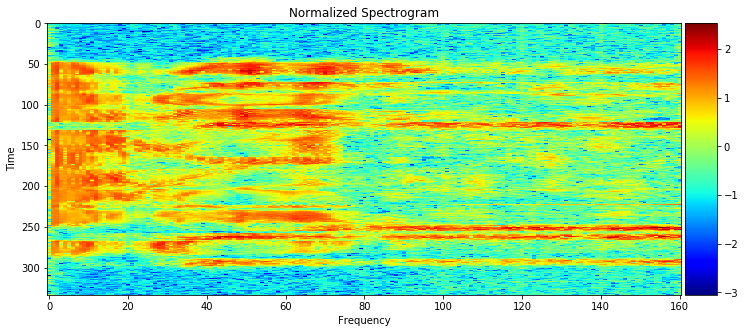

**Shape of Spectrogram** : (334, 161)

In [4]:

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

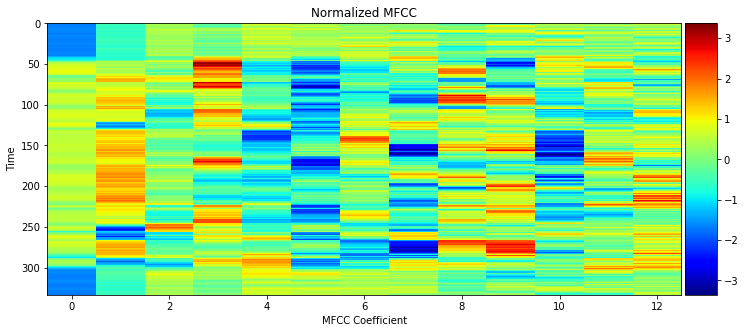

**Shape of MFCC** : (334, 13)

In [5]:
# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))